# IMPORTS

In [2]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import PIL

# MY FUNCTIONS
## regridding

In [86]:
def regrid(data, variable_str, new_name_str):
    lons = data['lon'].values
    lats = data['lat'].values
    time = data['time'].values
    variable = data[variable_str].values

    lons, lats = np.meshgrid(lons, lats)

    new_lon = np.arange(-127.45, -112.55, 0.1)
    new_lon = np.round(new_lon, 2)
    new_lat = np.arange(32.05, 45.95, 0.1)
    new_lat = np.round(new_lat, 2)
    new_lon_grid, new_lat_grid = np.meshgrid(new_lon, new_lat)

    print(new_lon)
    print(new_lat)

    original_points = np.array([lons.flatten(), lats.flatten()]).T  # Shape: (num_points, 2)
    regridded_data = []

    for time_step in range(variable.shape[0]):
        original_values = variable[time_step, :, :].flatten()  # Shape: (num_points,)
        new_values = griddata(original_points, original_values, (new_lon_grid, new_lat_grid), method='linear')
        regridded_data.append(new_values)

    regridded_data = np.array(regridded_data)
    
    new_data = xr.DataArray(regridded_data, coords=[time, new_lat, new_lon], dims=['time', 'lat', 'lon'])
    new_dataset = xr.Dataset({variable_str: new_data})

    # file_name = "/Users/nathanchen/Documents/JIFRESSE/data_2/" + new_name_str + ".nc"

    # new_dataset.to_netcdf(file_name)

    return new_dataset

## plotting (basemap)

In [89]:
def plot_basemap(data, variable_str, plot_title, date = 0, lower_lim = 0, upper_lim = 0):
    lons = data.variables['lon'][:]
    lats = data.variables['lat'][:]
    variable = data.variables[variable_str][:]

    mp = Basemap(projection = 'merc', 
                llcrnrlon = min(lons), 
                llcrnrlat = min(lats), 
                urcrnrlon = max(lons), 
                urcrnrlat = max(lats),
                resolution = 'i')

    lon, lat = np.meshgrid(lons, lats)
    x, y = mp(lon, lat)

    plt.figure(figsize=(12, 8))

    c_scheme = mp.pcolor(x, y, np.squeeze(variable[date,:,:]), cmap = 'jet')
    #inside it is time, lat, lon, choosing time zero

    c_bar = mp.colorbar(c_scheme, location = 'right', pad = '10%')
    c_bar.set_label(variable_str)

    parallels = np.arange(np.floor(min(lats)), np.ceil(max(lats)), 1)
    meridians = np.arange(np.floor(min(lons)), np.ceil(max(lons)), 1)
    mp.drawparallels(parallels, labels=[1,0,0,0], fontsize=10)
    mp.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10, rotation = 45)

    if lower_lim == 0 and upper_lim == 0:
        pass
    else:
        plt.clim(229, 323)


    plt.title(plot_title)

    mp.drawcoastlines()
    mp.drawstates()
    mp.drawcountries()

def plot_basemap_save(data, variable_str, plot_title, date_index = 0, lower_lim = 0, upper_lim = 0):
    lons = data.variables['lon'][:]
    lats = data.variables['lat'][:]
    variable = data.variables[variable_str][:]

    mp = Basemap(projection = 'merc', 
                llcrnrlon = min(lons), 
                llcrnrlat = min(lats), 
                urcrnrlon = max(lons), 
                urcrnrlat = max(lats),
                resolution = 'i')

    lon, lat = np.meshgrid(lons, lats)
    x, y = mp(lon, lat)

    plt.figure(figsize=(12, 8))

    c_scheme = mp.pcolor(x, y, np.squeeze(variable[date_index,:,:]), cmap = 'jet')
    #inside it is time, lat, lon, choosing time zero

    c_bar = mp.colorbar(c_scheme, location = 'right', pad = '10%')
    c_bar.set_label(variable_str)

    parallels = np.arange(np.floor(min(lats)), np.ceil(max(lats)), 1)
    meridians = np.arange(np.floor(min(lons)), np.ceil(max(lons)), 1)
    mp.drawparallels(parallels, labels=[1,0,0,0], fontsize=10)
    mp.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10, rotation = 45)

    date_string = np.datetime_as_string(data['time'][date_index].values, unit='m')

    if lower_lim == 0 and upper_lim == 0:
        pass
    else:
        plt.clim(229, 323)

    plt.title(plot_title + ' ' + date_string)

    mp.drawcoastlines()
    mp.drawstates()
    mp.drawcountries()

    file_name = plot_title + ' ' + date_string

    plt.savefig(f'{file_name}.jpg', dpi = 300, bbox_inches = 'tight')
    plt.clf()

## plotting (cartopy)

In [65]:
def plot_cartopy(data, variable_str, units_str, plot_title, date=0, lower_lim=0, upper_lim=0):
    lons = data.variables['lon'][:]
    lats = data.variables['lat'][:]
    variable = data.variables[variable_str][:]

    min_lon, max_lon = min(lons), max(lons)
    min_lat, max_lat = min(lats), max(lats)

    plt.figure(figsize=(12, 8))
    
    ax = plt.axes(projection=ccrs.Mercator())
    
    # Set the extent of the plot to match the data's lat-lon range
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    im = plt.imshow(variable[date,:,:], extent=(min(lons), max(lons), min(lats), max(lats)),
                    cmap='jet', origin='lower', transform=ccrs.PlateCarree())

    # Colorbar
    bar_label = variable_str + ' (' + units_str + ')'
    c_bar = plt.colorbar(im, label=bar_label, orientation='vertical', pad=0.1)


    # Set colorbar limits if specified
    if lower_lim != 0 or upper_lim != 0:
        c_bar.set_clim(lower_lim, upper_lim)

    # Gridlines and labels
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Add features (optional)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='--')

    # Set title and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')


    date_string = np.datetime_as_string(data['time'][date].values, unit='m')
    plt.title(plot_title + ' ' + date_string)


    plt.show()

# My data

## regridding

In [5]:
GFS = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/CA_GFS_0p25_f000_2017-2023.nc")
file_path = 'CA_GFS_0p25_f000_2017-2023.nc'  # Replace with your actual file path

# Directory to save the separate files
output_dir = '/Users/nathanchen/Documents/JIFRESSE/data_2/'  # Replace with your desired output directory

GFS_empty_days_filled = GFS.interpolate_na(dim='time', method='linear')

# # Iterate through each variable in the dataset
# for var_name in GFS_empty_days_filled.data_vars:
#     # Create a new dataset with only the current variable and its coordinates
#     single_var_data = GFS_empty_days_filled[[var_name]]
    
#     # Add relevant coordinates to the new dataset
#     for coord in GFS_empty_days_filled.coords:
#         if coord not in single_var_data.coords:
#             single_var_data = single_var_data.assign_coords({coord: GFS_empty_days_filled.coords[coord]})
    
#     # Define the output file path
#     output_file_path = f"{output_dir}GFS_{var_name}.nc"
    
#     # Save the new dataset to a NetCDF file
#     single_var_data.to_netcdf(output_file_path, mode='w')
    
#     print(f"Variable '{var_name}' saved to {output_file_path}")

# print("All variables have been saved to separate files.")

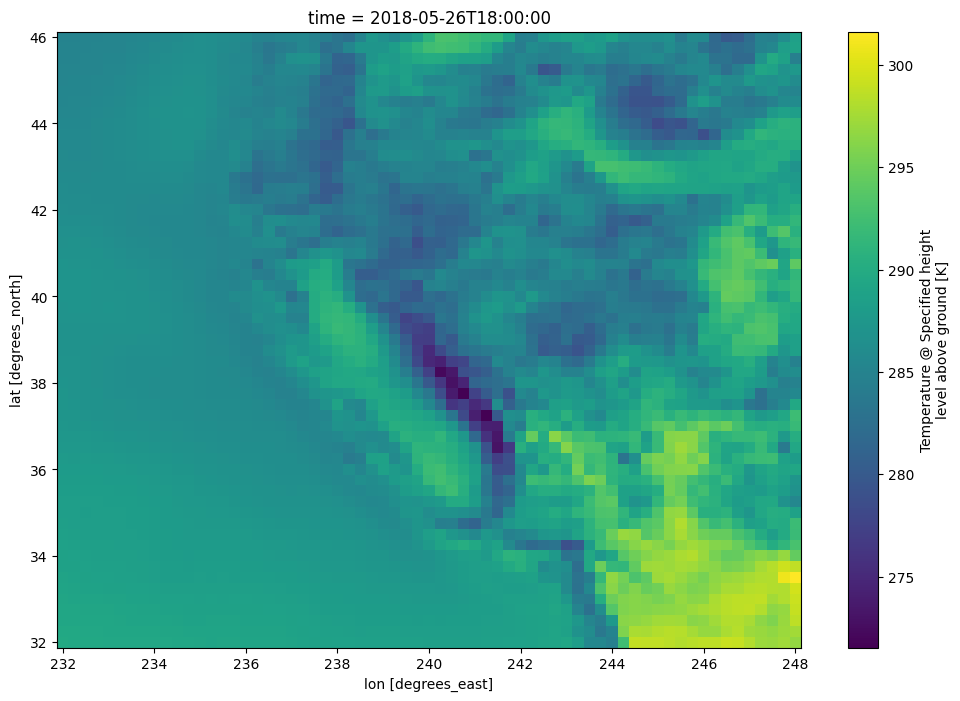

In [6]:
GFS_day = GFS_empty_days_filled.sel(time='2018-05-26T18:00:00.000000000')

plt.figure(figsize=(12,8))
GFS_day['tk2'].plot()
plt.show()

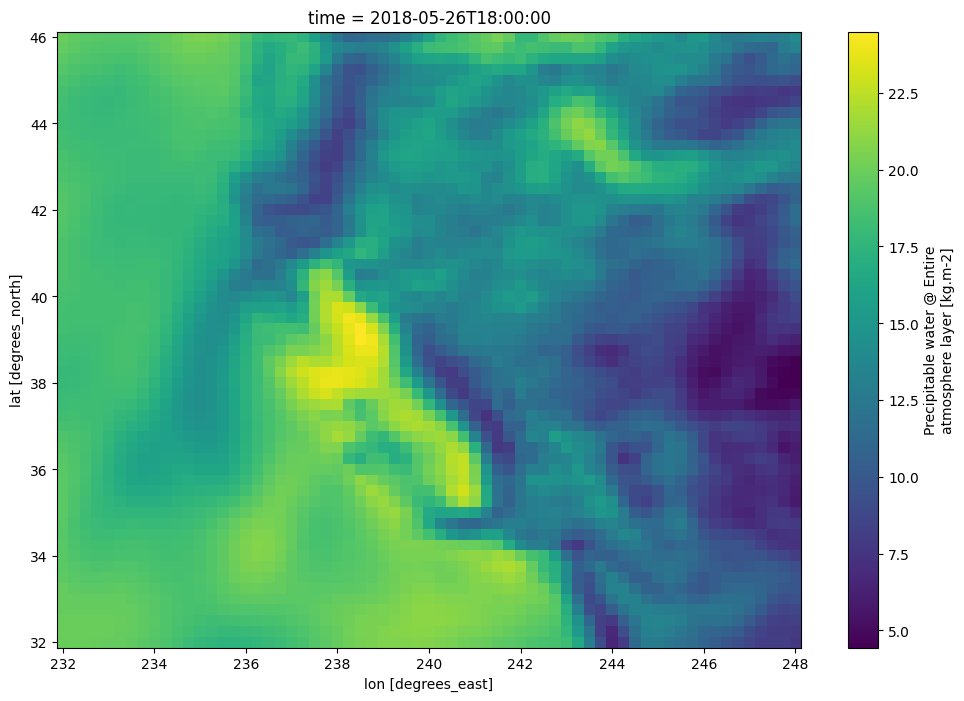

In [84]:
plt.figure(figsize=(12,8))
GFS_empty_days_filled.sel(time='2018-05-26T18:00:00.000000000')['pwv'].plot()
plt.show()

In [161]:
GFS_f000_pwv['pwv'].values.size

37879920

In [87]:
# -128.0 to -112.0
GFS_f000_pwv = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_pwv.nc")
GFS_f000_pwv_2 = regrid(GFS_f000_pwv, "pwv", "GFS_f000_pwv.regrid")

# GFS_f000_pwv_2 = xr.open_dataset("GFS_f000_pwv.regrid.nc")
GFS_f000_pwv_2
# # fix longitudes
# longitudes = GFS_f000_pwv['lon'].values
# adjusted_longitudes = (longitudes + 180) % 360 - 180
# GFS_f000_pwv = GFS_f000_pwv.assign_coords(lon=adjusted_longitudes)
# # fix time to numpy.datetime64
# time_var = GFS_f000_pwv['time'].values
# numpy_dates = np.array([np.datetime64(date) for date in time_var])
# GFS_f000_pwv = GFS_f000_pwv.assign_coords(time=numpy_dates)
# write to file
# GFS_f000_pwv.to_netcdf("GFS_f000_pwv.regrid2.nc")

[-127.45 -127.35 -127.25 -127.15 -127.05 -126.95 -126.85 -126.75 -126.65
 -126.55 -126.45 -126.35 -126.25 -126.15 -126.05 -125.95 -125.85 -125.75
 -125.65 -125.55 -125.45 -125.35 -125.25 -125.15 -125.05 -124.95 -124.85
 -124.75 -124.65 -124.55 -124.45 -124.35 -124.25 -124.15 -124.05 -123.95
 -123.85 -123.75 -123.65 -123.55 -123.45 -123.35 -123.25 -123.15 -123.05
 -122.95 -122.85 -122.75 -122.65 -122.55 -122.45 -122.35 -122.25 -122.15
 -122.05 -121.95 -121.85 -121.75 -121.65 -121.55 -121.45 -121.35 -121.25
 -121.15 -121.05 -120.95 -120.85 -120.75 -120.65 -120.55 -120.45 -120.35
 -120.25 -120.15 -120.05 -119.95 -119.85 -119.75 -119.65 -119.55 -119.45
 -119.35 -119.25 -119.15 -119.05 -118.95 -118.85 -118.75 -118.65 -118.55
 -118.45 -118.35 -118.25 -118.15 -118.05 -117.95 -117.85 -117.75 -117.65
 -117.55 -117.45 -117.35 -117.25 -117.15 -117.05 -116.95 -116.85 -116.75
 -116.65 -116.55 -116.45 -116.35 -116.25 -116.15 -116.05 -115.95 -115.85
 -115.75 -115.65 -115.55 -115.45 -115.35 -115.25 -1

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 10224, lat: 140, lon: 150)
Coordinates:
  * time     (time) datetime64[ns] 82kB 2016-12-31T12:00:00 ... 2023-12-31T06...
  * lat      (lat) float64 1kB 32.05 32.15 32.25 32.35 ... 45.75 45.85 45.95
  * lon      (lon) float64 1kB -127.5 -127.3 -127.2 ... -112.8 -112.7 -112.5
Data variables:
    pwv      (time, lat, lon) float64 2GB nan nan nan nan ... nan nan nan nan

In [89]:
GFS_f000_pwv = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_pwv.nc")

# Adjust longitudes to be within [-180, 180]
longitudes = GFS_f000_pwv['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f000_pwv = GFS_f000_pwv.assign_coords(lon=adjusted_longitudes)

# Define new longitude and latitude grids
new_lon = np.arange(-127.45, -112.55, 0.1)
new_lat = np.arange(32.05, 45.95, 0.1)

# Create meshgrid for new coordinates
new_lon_grid, new_lat_grid = np.meshgrid(new_lon, new_lat)

# Initialize an empty array for the regridded dataset
regridded_pwv = np.zeros((len(GFS_f000_pwv['time']), len(new_lat), len(new_lon)))

# Interpolate each time step separately
for i, time_step in enumerate(GFS_f000_pwv['time']):
    # Get original longitude and latitude meshgrid
    original_lon, original_lat = np.meshgrid(GFS_f000_pwv['lon'], GFS_f000_pwv['lat'])
    original_points = np.array([original_lon.flatten(), original_lat.flatten()]).T
    
    # Get original values and flatten them
    original_values = GFS_f000_pwv['pwv'][i, :, :].values.flatten()

    # Perform interpolation using griddata
    regridded_pwv[i, :, :] = griddata(original_points, original_values, (new_lon_grid, new_lat_grid), method='linear')

# Create a new xarray Dataset for the regridded data
new_dataset = xr.Dataset({
    'pwv': (['time', 'lat', 'lon'], regridded_pwv),
}, coords={'time': GFS_f000_pwv['time'], 'lat': new_lat, 'lon': new_lon})


# Optionally, save the new dataset to a file
# new_dataset.to_netcdf('regridded_dataset.nc')

# Print the new dataset
new_dataset

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 10224, lat: 140, lon: 150)
Coordinates:
  * time     (time) datetime64[ns] 82kB 2016-12-31T12:00:00 ... 2023-12-31T06...
  * lat      (lat) float64 1kB 32.05 32.15 32.25 32.35 ... 45.75 45.85 45.95
  * lon      (lon) float64 1kB -127.5 -127.4 -127.3 ... -112.8 -112.7 -112.6
Data variables:
    pwv      (time, lat, lon) float64 2GB 16.02 16.02 16.02 ... 6.279 6.061

In [94]:
np.isnan(new_dataset.pwv.values).sum()

0

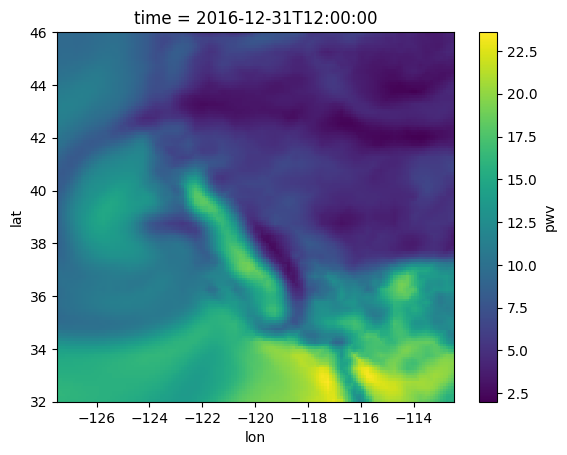

In [98]:
new_dataset.pwv[0].plot()

In [85]:
GFS_f000_pwv = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data_2/GFS_pwv.nc")

longitudes = GFS_f000_pwv['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f000_pwv = GFS_f000_pwv.assign_coords(lon=adjusted_longitudes)

new_lon = np.arange(-127.45, -112.55, 0.1)
new_lon = np.round(new_lon, 2)
new_lat = np.arange(32.05, 45.95, 0.1)
new_lat = np.round(new_lat, 2)

# print(lons.min(), lons.max())
# print(lats.min(), lats.max())

# print(new_lon)
# print(new_lat)

new_dataset = xr.Dataset()
new_dataset['lat'] = new_lat
new_dataset['lon'] = new_lon
new_dataset['time'] = GFS_f000_pwv['time']

for time_step in range(0, 5):
    original_values = GFS_f000_pwv.isel(time=0)  # Shape: (num_points,)
    new_values = original_values.interp(lat=new_lat, lon=new_lon)
    new_dataset[time_step, :, :] = new_values


ValueError: Unsupported key-type <class 'tuple'>

In [65]:
GFS_f000_pwv['pwv'].shape[0]

10224

In [62]:
na_sums = []

# Iterate over each time coordinate
# for time in new_dataset.time.values:
    # Select the data for the current time coordinate
# data_at_time = new_dataset.sel(time=time)

# # Count the number of NA values and add to the list
# na_sums.append(np.isnan(data_at_time).sum())

print(na_sums)
new_dataset.time.values
data_at_time = new_dataset.sel(time=new_dataset.time.values[0])
data_at_time.sel(lat = 46.05, lon = -112.0, method = 'nearest')


new_lon = np.arange(-127.45, -112.55, 0.1)
new_lon = np.round(new_lon, 2)
new_lat = np.arange(32.05, 45.95, 0.1)
new_lat = np.round(new_lat, 2)

test = GFS_f000_pwv.isel(time=0)

testi = test.interp(lat=new_lat, lon=new_lon)
print(new_lon, new_lat)
np.isnan(testi.pwv.values).sum()

[]
[-127.45 -127.35 -127.25 -127.15 -127.05 -126.95 -126.85 -126.75 -126.65
 -126.55 -126.45 -126.35 -126.25 -126.15 -126.05 -125.95 -125.85 -125.75
 -125.65 -125.55 -125.45 -125.35 -125.25 -125.15 -125.05 -124.95 -124.85
 -124.75 -124.65 -124.55 -124.45 -124.35 -124.25 -124.15 -124.05 -123.95
 -123.85 -123.75 -123.65 -123.55 -123.45 -123.35 -123.25 -123.15 -123.05
 -122.95 -122.85 -122.75 -122.65 -122.55 -122.45 -122.35 -122.25 -122.15
 -122.05 -121.95 -121.85 -121.75 -121.65 -121.55 -121.45 -121.35 -121.25
 -121.15 -121.05 -120.95 -120.85 -120.75 -120.65 -120.55 -120.45 -120.35
 -120.25 -120.15 -120.05 -119.95 -119.85 -119.75 -119.65 -119.55 -119.45
 -119.35 -119.25 -119.15 -119.05 -118.95 -118.85 -118.75 -118.65 -118.55
 -118.45 -118.35 -118.25 -118.15 -118.05 -117.95 -117.85 -117.75 -117.65
 -117.55 -117.45 -117.35 -117.25 -117.15 -117.05 -116.95 -116.85 -116.75
 -116.65 -116.55 -116.45 -116.35 -116.25 -116.15 -116.05 -115.95 -115.85
 -115.75 -115.65 -115.55 -115.45 -115.35 -115.25

0

In [131]:
longitudes = GFS_f000_pwv_2['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f000_pwv_2 = GFS_f000_pwv_2.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f000_pwv_2['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f000_pwv_2 = GFS_f000_pwv_2.assign_coords(time=numpy_dates)
GFS_f000_pwv_2

<xarray.Dataset> Size: 2GB
Dimensions:  (lat: 141, time: 10224, lon: 161)
Coordinates:
  * lat      (lat) float64 1kB 32.0 32.1 32.2 32.3 32.4 ... 45.7 45.8 45.9 46.0
  * lon      (lon) float64 1kB -128.0 -127.9 -127.8 ... -112.2 -112.1 -112.0
  * time     (time) datetime64[ns] 82kB 2016-12-31T12:00:00 ... 2023-12-31T06...
Data variables:
    pwv      (time, lat, lon) float64 2GB ...

In [106]:
#-128.0 to -112.0
#32.0 to 46.0
nan_mask = np.isnan(GFS_f000_pwv_2['pwv'].values)

# Find indices of NaN values along the 'time' dimension
nan_indices = np.where(nan_mask)
nan_indices
# nan_times = GFS_f000_pwv['time'].values[nan_indices_time]
# len(np.unique(nan_times))
#[2045, 9196, 9247]
# GFS_f000_pwv
# plot_cartopy(GFS_f000_pwv, "pwv", " ", "plot of pwv on")

(array([    0,     0,     0, ..., 10223, 10223, 10223]),
 array([140, 140, 140, ..., 140, 140, 140]),
 array([  0,   1,   2, ..., 158, 159, 160]))

In [102]:
#32.00 to 46.00
#232.00 to 248.00
GFS['time'].dtype

dtype('<M8[ns]')

In [105]:
#32.00 to 46.00
#-127.5 to -112.5

aod = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/MERRA2_6hrly.AODANA.2017-2023.nc")

Time coordinates are in numpy datetime64 format: True


In [109]:
#31.95 to 45.95
#-127.95 to -111.95

imerg = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/IMERG_6hrly.2017-2023.nc")
imerg['lat']
# adjusted_lat = np.round(imerg['lat'].astype(np.float64) / 0.05) * 0.05
adjusted_lat = np.round(imerg['lat'], decimals=2)
# print(adjusted_lat)
imerg = imerg.assign_coords(lat=adjusted_lat)
# adjusted_lon = np.round(imerg['lon'].astype(np.float64) / 0.05) * 0.05
adjusted_lon = np.round(imerg['lon'], decimals=2)
imerg = imerg.assign_coords(lon=adjusted_lon)
imerg['precipitation'].values.size

232095024

In [107]:
imerg = xr.open_dataset("/Users/nathanchen/Documents/JIFRESSE/data/IMERG_6hrly.2017-2023.nc")
imerg

<xarray.Dataset> Size: 928MB
Dimensions:        (time: 10224, lat: 141, lon: 161)
Coordinates:
  * time           (time) object 82kB 2017-01-01 00:00:00 ... 2023-12-31 18:0...
  * lat            (lat) float32 564B 31.95 32.05 32.15 ... 45.75 45.85 45.95
  * lon            (lon) float32 644B -127.9 -127.8 -127.8 ... -112.0 -111.9
Data variables:
    precipitation  (time, lon, lat) float32 928MB ...
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/07;\nDOIauth...
    FileInfo:                        DataFormatVersion=7e;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         Thu Jun 27 07:02:16 2024: ncrcat 3B-HHR....
    NCO:                             netCDF Operators version 4.8.1 (Homepage...

In [110]:
imerg['time'].dtype

dtype('O')

In [193]:
GFS_f000_tk2 = xr.open_dataset("GFS_tk2.nc")
GFS_f000_tk2
regrid(GFS_f000_tk2, "tk2", "GFS_f000_tk2.regrid")
GFS_f000_tk2 = xr.open_dataset("GFS_f000_tk2.regrid.nc")
GFS_f000_tk2
# fix longitudes
longitudes = GFS_f000_tk2['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f000_tk2 = GFS_f000_tk2.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f000_tk2['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f000_tk2 = GFS_f000_tk2.assign_coords(time=numpy_dates)
#write to file
GFS_f000_tk2.to_netcdf("GFS_f000_tk2.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [194]:
GFS_f000_qv2 = xr.open_dataset("GFS_qv2.nc")
GFS_f000_qv2
regrid(GFS_f000_qv2, "qv2", "GFS_f000_qv2.regrid")
GFS_f000_qv2 = xr.open_dataset("GFS_f000_qv2.regrid.nc")
GFS_f000_qv2
# fix longitudes
longitudes = GFS_f000_qv2['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f000_qv2 = GFS_f000_qv2.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f000_qv2['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f000_qv2 = GFS_f000_qv2.assign_coords(time=numpy_dates)
#write to file
GFS_f000_qv2.to_netcdf("GFS_f000_qv2.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [192]:
GFS_f000_u10 = xr.open_dataset("GFS_u10.nc")
GFS_f000_u10
regrid(GFS_f000_u10, "u10", "GFS_f000_u10.regrid")
GFS_f000_u10 = xr.open_dataset("GFS_f000_u10.regrid.nc")
GFS_f000_u10
# fix longitudes
longitudes = GFS_f000_u10['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f000_u10 = GFS_f000_u10.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f000_u10['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f000_u10 = GFS_f000_u10.assign_coords(time=numpy_dates)
#write to file
GFS_f000_u10.to_netcdf("GFS_f000_u10.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [195]:
GFS_f000_v10 = xr.open_dataset("GFS_v10.nc")
GFS_f000_v10
regrid(GFS_f000_v10, "v10", "GFS_f000_v10.regrid")
GFS_f000_v10 = xr.open_dataset("GFS_f000_v10.regrid.nc")
GFS_f000_v10
# fix longitudes
longitudes = GFS_f000_v10['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f000_v10 = GFS_f000_v10.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f000_v10['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f000_v10 = GFS_f000_v10.assign_coords(time=numpy_dates)
#write to file
GFS_f000_v10.to_netcdf("GFS_f000_v10.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [8]:
# GFS_f000_cape = xr.open_dataset("GFS_cape.nc")
# GFS_f000_cape
# regrid(GFS_f000_cape, "cape", "GFS_f000_cape.regrid")
# GFS_f000_cape = xr.open_dataset("GFS_f000_cape.regrid.nc")
GFS_f000_cape
# # fix longitudes
longitudes = GFS_f000_cape['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f000_cape = GFS_f000_cape.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f000_cape['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f000_cape = GFS_f000_cape.assign_coords(time=numpy_dates)
#write to file
GFS_f000_cape.to_netcdf("GFS_f000_cape.regrid2.nc")

In [197]:
GFS_f000_cin = xr.open_dataset("GFS_cin.nc")
GFS_f000_cin
regrid(GFS_f000_cin, "cin", "GFS_f000_cin.regrid")
GFS_f000_cin = xr.open_dataset("GFS_f000_cin.regrid.nc")
GFS_f000_cin
# fix longitudes
longitudes = GFS_f000_cin['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f000_cin = GFS_f000_cin.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f000_cin['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f000_cin = GFS_f000_cin.assign_coords(time=numpy_dates)
#write to file
GFS_f000_cin.to_netcdf("GFS_f000_cin.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [198]:
GFS_f000_ps = xr.open_dataset("GFS_ps.nc")
GFS_f000_ps
regrid(GFS_f000_ps, "ps", "GFS_f000_ps.regrid")
GFS_f000_ps = xr.open_dataset("GFS_f000_ps.regrid.nc")
GFS_f000_ps
# fix longitudes
longitudes = GFS_f000_ps['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f000_ps = GFS_f000_ps.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f000_ps['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f000_ps = GFS_f000_ps.assign_coords(time=numpy_dates)
#write to file
GFS_f000_ps.to_netcdf("GFS_f000_ps.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [199]:
GFS_f000_pr = xr.open_dataset("GFS_pr.nc")
GFS_f000_pr
regrid(GFS_f000_pr, "pr", "GFS_f000_pr.regrid")
GFS_f000_pr = xr.open_dataset("GFS_f000_pr.regrid.nc")
GFS_f000_pr
# fix longitudes
longitudes = GFS_f000_pr['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f000_pr = GFS_f000_pr.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f000_pr['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f000_pr = GFS_f000_pr.assign_coords(time=numpy_dates)
#write to file
GFS_f000_pr.to_netcdf("GFS_f000_pr.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [200]:
GFS_f000_cfr = xr.open_dataset("GFS_cfr.nc")
GFS_f000_cfr
regrid(GFS_f000_cfr, "cfr", "GFS_f000_cfr.regrid")
GFS_f000_cfr = xr.open_dataset("GFS_f000_cfr.regrid.nc")
GFS_f000_cfr
# fix longitudes
longitudes = GFS_f000_cfr['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f000_cfr = GFS_f000_cfr.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f000_cfr['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f000_cfr = GFS_f000_cfr.assign_coords(time=numpy_dates)
#write to file
GFS_f000_cfr.to_netcdf("GFS_f000_cfr.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [201]:
GFS_f000_dbz = xr.open_dataset("GFS_dbz.nc")
GFS_f000_dbz
regrid(GFS_f000_dbz, "dbz", "GFS_f000_dbz.regrid")
GFS_f000_dbz = xr.open_dataset("GFS_f000_dbz.regrid.nc")
GFS_f000_dbz
# fix longitudes
longitudes = GFS_f000_dbz['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f000_dbz = GFS_f000_dbz.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f000_dbz['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f000_dbz = GFS_f000_dbz.assign_coords(time=numpy_dates)
#write to file
GFS_f000_dbz.to_netcdf("GFS_f000_dbz.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [202]:
GFS_f000_u700 = xr.open_dataset("GFS_u700.nc")
GFS_f000_u700
regrid(GFS_f000_u700, "u700", "GFS_f000_u700.regrid")
GFS_f000_u700 = xr.open_dataset("GFS_f000_u700.regrid.nc")
GFS_f000_u700
# fix longitudes
longitudes = GFS_f000_u700['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f000_u700 = GFS_f000_u700.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f000_u700['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f000_u700 = GFS_f000_u700.assign_coords(time=numpy_dates)
#write to file
GFS_f000_u700.to_netcdf("GFS_f000_u700.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [203]:
GFS_f000_v700 = xr.open_dataset("GFS_v700.nc")
GFS_f000_v700
regrid(GFS_f000_v700, "v700", "GFS_f000_v700.regrid")
GFS_f000_v700 = xr.open_dataset("GFS_f000_v700.regrid.nc")
GFS_f000_v700
# fix longitudes
longitudes = GFS_f000_v700['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f000_v700 = GFS_f000_v700.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f000_v700['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f000_v700 = GFS_f000_v700.assign_coords(time=numpy_dates)
#write to file
GFS_f000_v700.to_netcdf("GFS_f000_v700.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [187]:
file_path = 'CA_GFS_0p25_f012_2017-2023.nc'  # Replace with your actual file path

# Directory to save the separate files
output_dir = '/Users/nathanchen/Documents/JIFRESSE/data/'  # Replace with your desired output directory

# Iterate through each variable in the dataset
for var_name in GFS.data_vars:
    # Create a new dataset with only the current variable and its coordinates
    single_var_data = GFS[[var_name]]
    
    # Add relevant coordinates to the new dataset
    for coord in GFS.coords:
        if coord not in single_var_data.coords:
            single_var_data = single_var_data.assign_coords({coord: GFS.coords[coord]})
    
    # Define the output file path
    output_file_path = f"{output_dir}GFS_12{var_name}.nc"
    
    # Save the new dataset to a NetCDF file
    single_var_data.to_netcdf(output_file_path)
    
    print(f"Variable '{var_name}' saved to {output_file_path}")

print("All variables have been saved to separate files.")

Variable 'pwv' saved to /Users/nathanchen/Documents/JIFRESSE/data/GFS_12pwv.nc
Variable 'cw' saved to /Users/nathanchen/Documents/JIFRESSE/data/GFS_12cw.nc
Variable 'tk2' saved to /Users/nathanchen/Documents/JIFRESSE/data/GFS_12tk2.nc
Variable 'qv2' saved to /Users/nathanchen/Documents/JIFRESSE/data/GFS_12qv2.nc
Variable 'u10' saved to /Users/nathanchen/Documents/JIFRESSE/data/GFS_12u10.nc
Variable 'v10' saved to /Users/nathanchen/Documents/JIFRESSE/data/GFS_12v10.nc
Variable 'cape' saved to /Users/nathanchen/Documents/JIFRESSE/data/GFS_12cape.nc
Variable 'cin' saved to /Users/nathanchen/Documents/JIFRESSE/data/GFS_12cin.nc
Variable 'ps' saved to /Users/nathanchen/Documents/JIFRESSE/data/GFS_12ps.nc
Variable 'pr' saved to /Users/nathanchen/Documents/JIFRESSE/data/GFS_12pr.nc
Variable 'cfr' saved to /Users/nathanchen/Documents/JIFRESSE/data/GFS_12cfr.nc
Variable 'dbz' saved to /Users/nathanchen/Documents/JIFRESSE/data/GFS_12dbz.nc
Variable 'u700' saved to /Users/nathanchen/Documents/JIF

In [205]:
GFS_f012_pwv = xr.open_dataset("GFS_12pwv.nc")
GFS_f012_pwv
regrid(GFS_f012_pwv, "pwv", "GFS_f012_pwv.regrid")
GFS_f012_pwv = xr.open_dataset("GFS_f012_pwv.regrid.nc")
GFS_f012_pwv
# fix longitudes
longitudes = GFS_f012_pwv['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f012_pwv = GFS_f012_pwv.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f012_pwv['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f012_pwv = GFS_f012_pwv.assign_coords(time=numpy_dates)
#write to file
GFS_f012_pwv.to_netcdf("GFS_f012_pwv.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [206]:
GFS_f012_tk2 = xr.open_dataset("GFS_12tk2.nc")
GFS_f012_tk2
regrid(GFS_f012_tk2, "tk2", "GFS_f012_tk2.regrid")
GFS_f012_tk2 = xr.open_dataset("GFS_f012_tk2.regrid.nc")
GFS_f012_tk2
# fix longitudes
longitudes = GFS_f012_tk2['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f012_tk2 = GFS_f012_tk2.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f012_tk2['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f012_tk2 = GFS_f012_tk2.assign_coords(time=numpy_dates)
#write to file
GFS_f012_tk2.to_netcdf("GFS_f012_tk2.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [207]:
GFS_f012_qv2 = xr.open_dataset("GFS_12qv2.nc")
GFS_f012_qv2
regrid(GFS_f012_qv2, "qv2", "GFS_f012_qv2.regrid")
GFS_f012_qv2 = xr.open_dataset("GFS_f012_qv2.regrid.nc")
GFS_f012_qv2
# fix longitudes
longitudes = GFS_f012_qv2['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f012_qv2 = GFS_f012_qv2.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f012_qv2['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f012_qv2 = GFS_f012_qv2.assign_coords(time=numpy_dates)
#write to file
GFS_f012_qv2.to_netcdf("GFS_f012_qv2.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [208]:
GFS_f012_u10 = xr.open_dataset("GFS_12u10.nc")
GFS_f012_u10
regrid(GFS_f012_u10, "u10", "GFS_f012_u10.regrid")
GFS_f012_u10 = xr.open_dataset("GFS_f012_u10.regrid.nc")
GFS_f012_u10
# fix longitudes
longitudes = GFS_f012_u10['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f012_u10 = GFS_f012_u10.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f012_u10['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f012_u10 = GFS_f012_u10.assign_coords(time=numpy_dates)
#write to file
GFS_f012_u10.to_netcdf("GFS_f012_u10.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [209]:
GFS_f012_v10 = xr.open_dataset("GFS_12v10.nc")
GFS_f012_v10
regrid(GFS_f012_v10, "v10", "GFS_f012_v10.regrid")
GFS_f012_v10 = xr.open_dataset("GFS_f012_v10.regrid.nc")
GFS_f012_v10
# fix longitudes
longitudes = GFS_f012_v10['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f012_v10 = GFS_f012_v10.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f012_v10['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f012_v10 = GFS_f012_v10.assign_coords(time=numpy_dates)
#write to file
GFS_f012_v10.to_netcdf("GFS_f012_v10.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [11]:
GFS_f012_cape = xr.open_dataset("GFS12_cape.nc")
GFS_f012_cape
regrid(GFS_f012_cape, "cape", "GFS_f012_cape.regrid")
GFS_f012_cape = xr.open_dataset("GFS_f012_cape.regrid.nc")
GFS_f012_cape
# fix longitudes
longitudes = GFS_f012_cape['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f012_cape = GFS_f012_cape.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f012_cape['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f012_cape = GFS_f012_cape.assign_coords(time=numpy_dates)
#write to file
GFS_f012_cape.to_netcdf("GFS_f012_cape.regrid2.nc")

In [210]:
GFS_f012_cin = xr.open_dataset("GFS_12cin.nc")
GFS_f012_cin
regrid(GFS_f012_cin, "cin", "GFS_f012_cin.regrid")
GFS_f012_cin = xr.open_dataset("GFS_f012_cin.regrid.nc")
GFS_f012_cin
# fix longitudes
longitudes = GFS_f012_cin['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f012_cin = GFS_f012_cin.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f012_cin['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f012_cin = GFS_f012_cin.assign_coords(time=numpy_dates)
#write to file
GFS_f012_cin.to_netcdf("GFS_f012_cin.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [211]:
GFS_f012_ps = xr.open_dataset("GFS_12ps.nc")
GFS_f012_ps
regrid(GFS_f012_ps, "ps", "GFS_f012_ps.regrid")
GFS_f012_ps = xr.open_dataset("GFS_f012_ps.regrid.nc")
GFS_f012_ps
# fix longitudes
longitudes = GFS_f012_ps['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f012_ps = GFS_f012_ps.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f012_ps['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f012_ps = GFS_f012_ps.assign_coords(time=numpy_dates)
#write to file
GFS_f012_ps.to_netcdf("GFS_f012_ps.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [212]:
GFS_f012_pr = xr.open_dataset("GFS_12pr.nc")
GFS_f012_pr
regrid(GFS_f012_pr, "pr", "GFS_f012_pr.regrid")
GFS_f012_pr = xr.open_dataset("GFS_f012_pr.regrid.nc")
GFS_f012_pr
# fix longitudes
longitudes = GFS_f012_pr['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f012_pr = GFS_f012_pr.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f012_pr['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f012_pr = GFS_f012_pr.assign_coords(time=numpy_dates)
#write to file
GFS_f012_pr.to_netcdf("GFS_f012_pr.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [213]:
GFS_f012_cfr = xr.open_dataset("GFS_12cfr.nc")
GFS_f012_cfr
regrid(GFS_f012_cfr, "cfr", "GFS_f012_cfr.regrid")
GFS_f012_cfr = xr.open_dataset("GFS_f012_cfr.regrid.nc")
GFS_f012_cfr
# fix longitudes
longitudes = GFS_f012_cfr['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f012_cfr = GFS_f012_cfr.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f012_cfr['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f012_cfr = GFS_f012_cfr.assign_coords(time=numpy_dates)
#write to file
GFS_f012_cfr.to_netcdf("GFS_f012_cfr.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [214]:
GFS_f012_dbz = xr.open_dataset("GFS_12dbz.nc")
GFS_f012_dbz
regrid(GFS_f012_dbz, "dbz", "GFS_f012_dbz.regrid")
GFS_f012_dbz = xr.open_dataset("GFS_f012_dbz.regrid.nc")
GFS_f012_dbz
# fix longitudes
longitudes = GFS_f012_dbz['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f012_dbz = GFS_f012_dbz.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f012_dbz['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f012_dbz = GFS_f012_dbz.assign_coords(time=numpy_dates)
#write to file
GFS_f012_dbz.to_netcdf("GFS_f012_dbz.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [ ]:
GFS_f012_u700 = xr.open_dataset("GFS_12u700.nc")
GFS_f012_u700
regrid(GFS_f012_u700, "u700", "GFS_f012_u700.regrid")
GFS_f012_u700 = xr.open_dataset("GFS_f012_u700.regrid.nc")
GFS_f012_u700
# fix longitudes
longitudes = GFS_f012_u700['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f012_u700 = GFS_f012_u700.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f012_u700['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f012_u700 = GFS_f012_u700.assign_coords(time=numpy_dates)
#write to file
GFS_f012_u700.to_netcdf("GFS_f012_u700.regrid2.nc")

In [182]:
GFS_f012_v700 = xr.open_dataset("GFS_12v700.nc")
GFS_f012_v700
regrid(GFS_f012_v700, "v700", "GFS_f012_v700.regrid")
GFS_f012_v700 = xr.open_dataset("GFS_f012_v700.regrid.nc")
GFS_f012_v700
# fix longitudes
longitudes = GFS_f012_v700['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
GFS_f012_v700 = GFS_f012_v700.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = GFS_f012_v700['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
GFS_f012_v700 = GFS_f012_v700.assign_coords(time=numpy_dates)
#write to file
GFS_f012_v700.to_netcdf("GFS_f012_v700.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [ ]:
#RAN
f000cw = xr.open_dataset("CA_GFS_0p25_f000_CW_2017-2023.nc")
f000cw
regrid(f000cw, "cw", "f000_cw.regrid")
f000cw_new = xr.open_dataset("f000_cw.regrid.nc")
f000cw_new
# fix longitudes
longitudes = f000cw_new['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
f000cw_new = f000cw_new.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = f000cw_new['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
f000cw_new = f000cw_new.assign_coords(time=numpy_dates)
#write to file
f000cw_new.to_netcdf("f000_cw.regrid2.nc")

In [170]:
f012cw = xr.open_dataset("CA_GFS_0p25_f012_CW_2017-2023.nc")
f012cw
regrid(f012cw, "cw", "f012_cw.regrid")
f012cw_new = xr.open_dataset("f012_cw.regrid.nc")
f012cw_new
# fix longitudes
longitudes = f012cw_new['lon'].values
adjusted_longitudes = (longitudes + 180) % 360 - 180
f012cw_new = f012cw_new.assign_coords(lon=adjusted_longitudes)
# fix time to numpy.datetime64
time_var = f012cw_new['time'].values
numpy_dates = np.array([np.datetime64(date) for date in time_var])
f012cw_new = f012cw_new.assign_coords(time=numpy_dates)
#write to file
f012cw_new.to_netcdf("f012_cw.regrid2.nc")

(65,)
(57,)
(57, 65)
(57, 65)
[[232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 ...
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]
 [232.  232.1 232.2 ... 247.8 247.9 248. ]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [154]:
#RAN
aodana = xr.open_dataset("MERRA2_6hrly.AODANA.2017-2023.nc")
aodana
regrid(aodana, "AODANA", "aodana.regrid")
aodana_new = xr.open_dataset("aodana.regrid.nc")

(25,)
(29,)
(29, 25)
(29, 25)
[[-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 ...
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [ ]:
#RAN
bcphilic = xr.open_dataset("MERRA2_6hrly.BCPHILIC.2017-2023.nc")
bcphilic
regrid(bcphilic, "BCPHILIC", "bcphilic.regrid")
bcphilic_new = xr.open_dataset("bcphilic.regrid.nc")
coordinate_data = bcphilic['lev']
# Add 'lev'
bcphilic_new.coords['lev'] = coordinate_data
bcphilic_new
#write to file
bcphilic_new.to_netcdf("bcphilic.regrid2.nc")

In [159]:
#RAN
bcphobic = xr.open_dataset("MERRA2_6hrly.BCPHOBIC.2017-2023.nc")
bcphobic
regrid(bcphobic, "BCPHOBIC", "bcphobic.regrid")
bcphobic_new = xr.open_dataset("bcphobic.regrid.nc")
coordinate_data = bcphobic['lev']
# Add 'lev'
bcphobic_new.coords['lev'] = coordinate_data
bcphobic_new
bcphobic_new.to_netcdf("bcphobic.regrid2.nc")

(25,)
(29,)
(29, 25)
(29, 25)
[[-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 ...
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [161]:
#RAN
du001 = xr.open_dataset("MERRA2_6hrly.DU001.2017-2023.nc")
du001
regrid(du001, "DU001", "du001.regrid")
du001_new = xr.open_dataset("du001.regrid.nc")
coordinate_data = du001['lev']
# Add 'lev'
du001_new.coords['lev'] = coordinate_data
du001_new
du001_new.to_netcdf("du001.regrid2.nc")

(25,)
(29,)
(29, 25)
(29, 25)
[[-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 ...
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [162]:
#RAN
du002 = xr.open_dataset("MERRA2_6hrly.DU002.2017-2023.nc")
du002
regrid(du002, "DU002", "du002.regrid")
du002_new = xr.open_dataset("du002.regrid.nc")
coordinate_data = du002['lev']
# Add 'lev'
du002_new.coords['lev'] = coordinate_data
du002_new
du002_new.to_netcdf("du002.regrid2.nc")

(25,)
(29,)
(29, 25)
(29, 25)
[[-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 ...
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [163]:
#RAN
du003 = xr.open_dataset("MERRA2_6hrly.DU003.2017-2023.nc")
du003
regrid(du003, "DU003", "du003.regrid")
du003_new = xr.open_dataset("du003.regrid.nc")
coordinate_data = du003['lev']
# Add 'lev'
du003_new.coords['lev'] = coordinate_data
du003_new
du003_new.to_netcdf("du003.regrid2.nc")

(25,)
(29,)
(29, 25)
(29, 25)
[[-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 ...
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [164]:
#RAN
du004 = xr.open_dataset("MERRA2_6hrly.DU004.2017-2023.nc")
du004
regrid(du004, "DU004", "du004.regrid")
du004_new = xr.open_dataset("du004.regrid.nc")
coordinate_data = du004['lev']
# Add 'lev'
du004_new.coords['lev'] = coordinate_data
du004_new
du004_new.to_netcdf("du004.regrid2.nc")

(25,)
(29,)
(29, 25)
(29, 25)
[[-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 ...
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [165]:
#RAN
du005 = xr.open_dataset("MERRA2_6hrly.DU005.2017-2023.nc")
du005
regrid(du005, "DU005", "du005.regrid")
du005_new = xr.open_dataset("du005.regrid.nc")
coordinate_data = du005['lev']
# Add 'lev'
du005_new.coords['lev'] = coordinate_data
du005_new
du005_new.to_netcdf("du005.regrid2.nc")

(25,)
(29,)
(29, 25)
(29, 25)
[[-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 ...
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [166]:
#RAN
ocphilic = xr.open_dataset("MERRA2_6hrly.OCPHILIC.2017-2023.nc")
ocphilic
regrid(ocphilic, "OCPHILIC", "ocphilic.regrid")
ocphilic_new = xr.open_dataset("ocphilic.regrid.nc")
coordinate_data = ocphilic['lev']
# Add 'lev'
ocphilic_new.coords['lev'] = coordinate_data
ocphilic_new
ocphilic_new.to_netcdf("ocphilic.regrid2.nc")

(25,)
(29,)
(29, 25)
(29, 25)
[[-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 ...
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [167]:
#RAN
ocphobic = xr.open_dataset("MERRA2_6hrly.OCPHOBIC.2017-2023.nc")
ocphobic
regrid(ocphobic, "OCPHOBIC", "ocphobic.regrid")
ocphobic_new = xr.open_dataset("ocphobic.regrid.nc")
coordinate_data = ocphobic['lev']
# Add 'lev'
ocphobic_new.coords['lev'] = coordinate_data
ocphobic_new
ocphobic_new.to_netcdf("ocphobic.regrid2.nc")

(25,)
(29,)
(29, 25)
(29, 25)
[[-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 ...
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [168]:
#RAN
so2 = xr.open_dataset("MERRA2_6hrly.SO2.2017-2023.nc")
so2
regrid(so2, "SO2", "so2.regrid")
so2_new = xr.open_dataset("so2.regrid.nc")
coordinate_data = so2['lev']
# Add 'lev'
so2_new.coords['lev'] = coordinate_data
so2_new
so2_new.to_netcdf("so2.regrid2.nc")

(25,)
(29,)
(29, 25)
(29, 25)
[[-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 ...
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [169]:
#RAN
so4 = xr.open_dataset("MERRA2_6hrly.SO4.2017-2023.nc")
so4
regrid(so4, "SO4", "so4.regrid")
so4_new = xr.open_dataset("so4.regrid.nc")
coordinate_data = so4['lev']
# Add 'lev'
so4_new.coords['lev'] = coordinate_data
so4_new
so4_new.to_netcdf("so4.regrid2.nc")

(25,)
(29,)
(29, 25)
(29, 25)
[[-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 ...
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]
 [-127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5]]
[[32.  32.  32.  ... 32.  32.  32. ]
 [32.1 32.1 32.1 ... 32.1 32.1 32.1]
 [32.2 32.2 32.2 ... 32.2 32.2 32.2]
 ...
 [45.8 45.8 45.8 ... 45.8 45.8 45.8]
 [45.9 45.9 45.9 ... 45.9 45.9 45.9]
 [46.  46.  46.  ... 46.  46.  46. ]]


In [ ]:
aodana = xr.open_dataset("MERRA2_6hrly.AODANA.2017-2023.nc")
data = xr.open_dataset("CA_GFS_0p25_f000_2017-2023.nc")

Minimum Latitude: 32.0
Minimum Longitude: -127.5
Maximum Latitude: 46.0
Maximum Longitude: -112.5


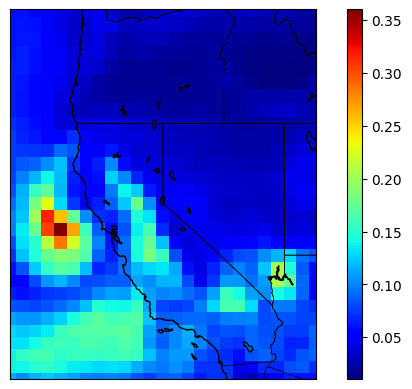

In [44]:
lons = aodana.variables['lon'][:]
lats = aodana.variables['lat'][:]
AODANA = aodana.variables['AODANA'][:]


print(f"Minimum Latitude: {min(lats)}")
print(f"Minimum Longitude: {min(lons)}")
print(f"Maximum Latitude: {max(lats)}")
print(f"Maximum Longitude: {max(lons)}")

mp = Basemap(projection = 'merc', 
             llcrnrlon = min(lons), 
             llcrnrlat = min(lats), 
             urcrnrlon = max(lons), 
             urcrnrlat = max(lats),
             resolution = 'i')

lon, lat = np.meshgrid(lons, lats)
x, y = mp(lon, lat)

c_scheme = mp.pcolor(x, y, np.squeeze(AODANA[0,:,:]), cmap = 'jet')
#inside it is time, lat, lon, choosing time zero

c_bar = mp.colorbar(c_scheme, location = 'right', pad = '10%')

mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

In [ ]:
# Extract variables
lons = data['lon'].values
lats = data['lat'].values
tk2 = data['tk2'].values  # Assuming 'tk2' is the variable name for temperature
time = data['time'].values

print(lons.shape)
print(lats.shape)

lons, lats = np.meshgrid(lons, lats)

print(lons.shape)
print(lats.shape)


new_lon = np.arange(np.min(lons), np.max(lons) + 0.1, 0.1)
new_lat = np.arange(np.min(lats), np.max(lats) + 0.1, 0.1)
new_lon_grid, new_lat_grid = np.meshgrid(new_lon, new_lat)

print(new_lon_grid)
print(new_lat_grid)

original_points = np.array([lons.flatten(), lats.flatten()]).T  # Shape: (num_points, 2)
regridded_data = []

for time_step in range(tk2.shape[0]):
    original_values = tk2[time_step, :, :].flatten()  # Shape: (num_points,)
    new_values = griddata(original_points, original_values, (new_lon_grid, new_lat_grid), method='linear')
    regridded_data.append(new_values)

regridded_data = np.array(regridded_data)
new_data = xr.DataArray(regridded_data, coords=[time, new_lat, new_lon], dims=['time', 'lat', 'lon'])
new_dataset = xr.Dataset({'tk2': new_data})
new_dataset.to_netcdf('regridded_data3.nc')

In [113]:
new_dataset.to_netcdf('regridded_data3.nc')

In [70]:
coordinate_data = bcphilic['lev']

# Add or update the coordinate variable in the target dataset
bcphilic_new.coords['lev'] = coordinate_data

bcphilic_new

<xarray.Dataset> Size: 2GB
Dimensions:   (time: 10224, lat: 141, lon: 151)
Coordinates:
  * time      (time) datetime64[ns] 82kB 2016-12-31T12:00:00 ... 2023-12-31T0...
  * lat       (lat) float64 1kB 32.0 32.1 32.2 32.3 32.4 ... 45.7 45.8 45.9 46.0
  * lon       (lon) float64 1kB -127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5
    lev       float64 8B 71.0
Data variables:
    BCPHILIC  (time, lat, lon) float64 2GB ...

/var/folders/vc/z6j_dxbj4wl_jhtyr4jzsbw40000gn/T/ipykernel_34340/3357256681.py:21: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  c_bar = mp.colorbar(c_scheme, location = 'right', pad = '10%')


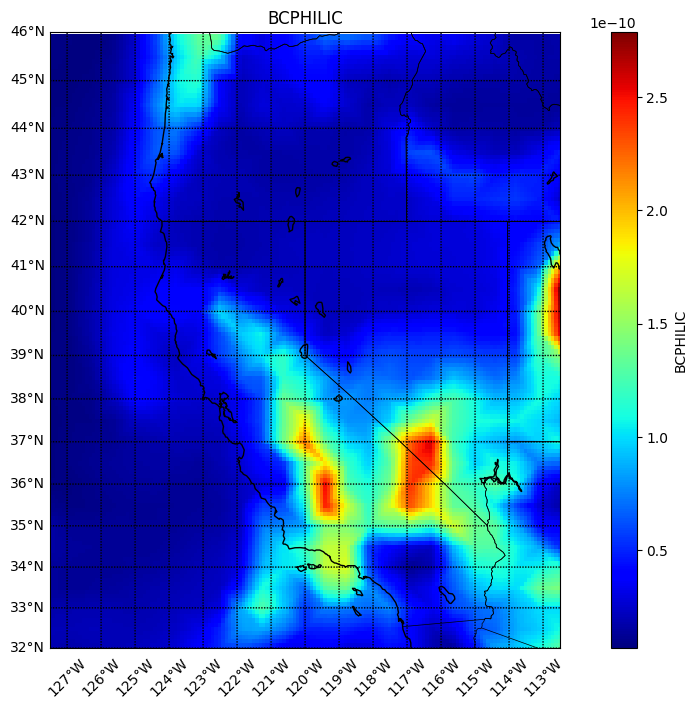

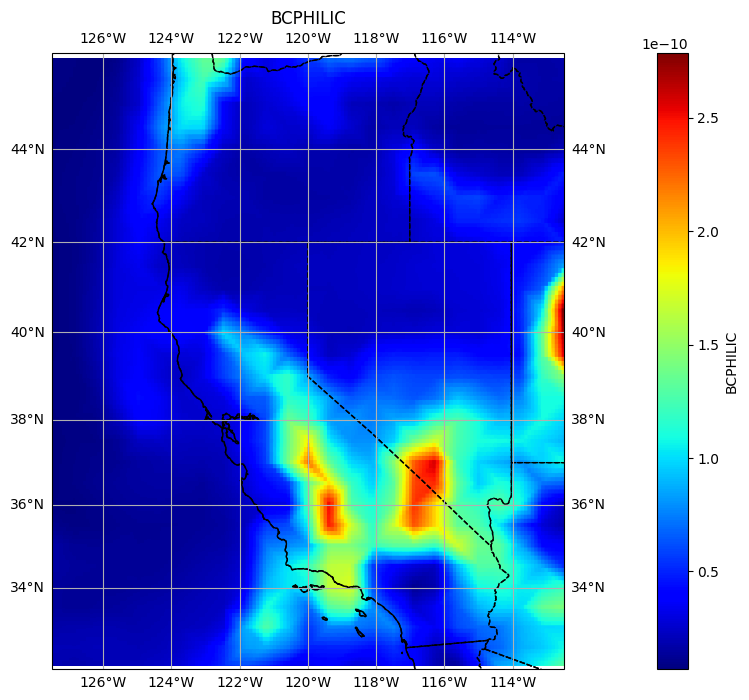

In [97]:
#  plot_basemap(bcphilic_new, "BCPHILIC", "BCPHILIC")
plot_cartopy(bcphilic_new, "BCPHILIC", "BCPHILIC")

In [ ]:
#plot_basemap(aodana_new, "AODANA", "AODANA levels", 56)
for i in range(0, 101):
    plot_basemap_save(aodana_new, "AODANA", "AODANA levels", i)

In [114]:
regridded = xr.open_dataset("regridded_data3.nc")

In [115]:
regridded

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 10224, lat: 141, lon: 161)
Coordinates:
  * time     (time) datetime64[ns] 82kB 2016-12-31T12:00:00 ... 2023-12-31T06...
  * lat      (lat) float64 1kB 32.0 32.1 32.2 32.3 32.4 ... 45.7 45.8 45.9 46.0
  * lon      (lon) float64 1kB 232.0 232.1 232.2 232.3 ... 247.8 247.9 248.0
Data variables:
    tk2      (time, lat, lon) float64 2GB ...

(array([1.06900000e+03, 3.19460000e+04, 4.76422000e+05, 4.75956000e+06,
        2.77447300e+07, 6.02308180e+07, 1.04170208e+08, 2.45134490e+07,
        7.90299100e+06, 5.50147000e+05]),
 array([229.47000122, 238.73500183, 248.00000244, 257.26500305,
        266.53000366, 275.79500427, 285.06000488, 294.32500549,
        303.5900061 , 312.85500671, 322.12000732]),
 <BarContainer object of 10 artists>)

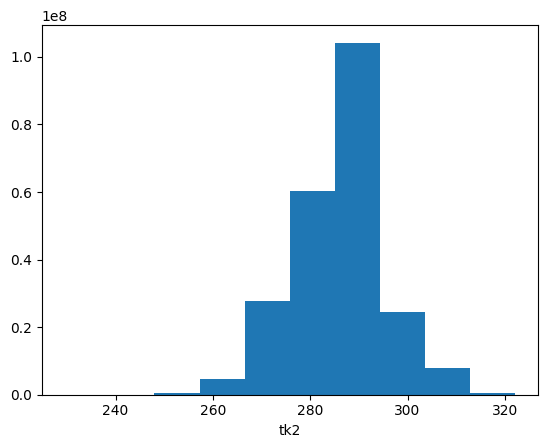

In [116]:
regridded.tk2.plot()

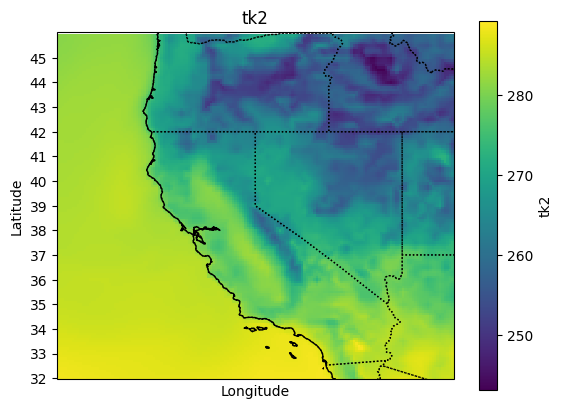

In [152]:
lons = regridded['lon'].values
lats = regridded['lat'].values

data_for_desired_date = regridded.isel(time = 0)

#print(data_for_desired_date)

np.min(lons), np.max(lons)
np.min(lats), np.max(lats)

plt.figure()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='black')

ax.set_yticks(range(int(np.min(lats)),int(np.max(lats)), 1), crs = ccrs.PlateCarree())
ax.set_xticks(range(int(np.min(lons)), int(np.max(lons)), 1), crs = ccrs.PlateCarree())



# ax.xaxis.set_label_position('bottom')
# ax.xaxis.tick_bottom()

data_for_desired_date['tk2'].plot()

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.title(f"tk2")

plt.show()

In [4]:
aodana_new = xr.open_dataset("aodana.regrid.nc")

In [5]:
aodana_new

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 10224, lat: 141, lon: 151)
Coordinates:
  * time     (time) datetime64[ns] 82kB 2016-12-31T12:00:00 ... 2023-12-31T06...
  * lat      (lat) float64 1kB 32.0 32.1 32.2 32.3 32.4 ... 45.7 45.8 45.9 46.0
  * lon      (lon) float64 1kB -127.5 -127.4 -127.3 ... -112.7 -112.6 -112.5
Data variables:
    AODANA   (time, lat, lon) float64 2GB ...

/var/folders/vc/z6j_dxbj4wl_jhtyr4jzsbw40000gn/T/ipykernel_32399/2808625008.py:20: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  c_bar = mp.colorbar(c_scheme, location = 'right', pad = '10%')


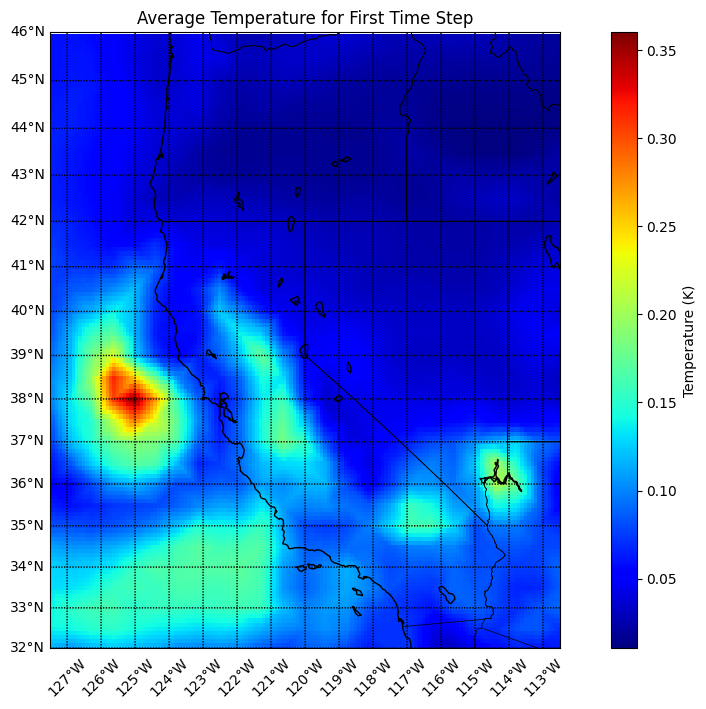

In [166]:
lons = aodana_new.variables['lon'][:]
lats = aodana_new.variables['lat'][:]
AODANA = aodana_new.variables['tk2'][:]

mp = Basemap(projection = 'merc', 
             llcrnrlon = min(lons), 
             llcrnrlat = min(lats), 
             urcrnrlon = max(lons), 
             urcrnrlat = max(lats),
             resolution = 'i')

lon, lat = np.meshgrid(lons, lats)
x, y = mp(lon, lat)

plt.figure(figsize=(12, 8))

c_scheme = mp.pcolor(x, y, np.squeeze(AODANA[0,:,:]), cmap = 'jet')
#inside it is time, lat, lon, choosing time zero

c_bar = mp.colorbar(c_scheme, location = 'right', pad = '10%')
c_bar.set_label('Temperature (K)')

parallels = np.arange(np.floor(min(lats)), np.ceil(max(lats)), 1)
meridians = np.arange(np.floor(min(lons)), np.ceil(max(lons)), 1)
mp.drawparallels(parallels, labels=[1,0,0,0], fontsize=10)
mp.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10, rotation = 45)

plt.title('Average Temperature for First Time Step')

mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

In [ ]:
#plot_basemap(aodana_new, "AODANA", "AODANA levels", 56)
for i in range(0, 101):
    plot_basemap_save(aodana_new, "AODANA", "AODANA levels", i)

In [23]:


aodana_new['time'][0].values

date_strings = np.datetime_as_string(aodana_new['time'][0].values, unit='m')

print(date_strings)

2016-12-31T12:00


In [55]:
# Define the directory where your images are stored
image_dir = '/Users/nathanchen/Documents/JIFRESSE/data/images_aodana/'

# Generate the list of image filenames
image_filenames = [f"{image_dir}AODANA levels {np.datetime_as_string(aodana_new['time'][i].values, unit='m')}.jpg" for i in range(1, 101)]

# Load images
image_frames = []
for filename in image_filenames:
    try:
        image = PIL.Image.open(filename)
        image_frames.append(image)
    except FileNotFoundError:
        print(f"File not found: {filename}")

# Save as GIF
if image_frames:
    image_frames[0].save(
        'aodana_timelapse.gif',
        format='GIF',
        append_images=image_frames[1:],
        save_all=True,
        duration=100,
        loop=0
    )
else:
    print("No images found to create GIF.")

In [72]:
imerg = xr.open_dataset("IMERG_6hrly.2017-2023.nc")

In [136]:
imerg['time']

<xarray.DataArray 'time' (time: 10224)> Size: 82kB
array([cftime.DatetimeJulian(2017, 1, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2017, 1, 1, 6, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2017, 1, 1, 12, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeJulian(2023, 12, 31, 6, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2023, 12, 31, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2023, 12, 31, 18, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 82kB 2017-01-01 00:00:00 ... 2023-12-31 18:00:00
Attributes:
    DimensionNames:  time
    Units:           seconds since 1980-01-06 00:00:00 UTC
    standard_name:   time
    LongName:        \nRepresentative time of data in \n\t\t\tseconds since 1...
    bounds:          time_bnds
    axis:            T
    origname:        time
    fullnamepath:    /Grid/time

TypeError: input must have type NumPy datetime

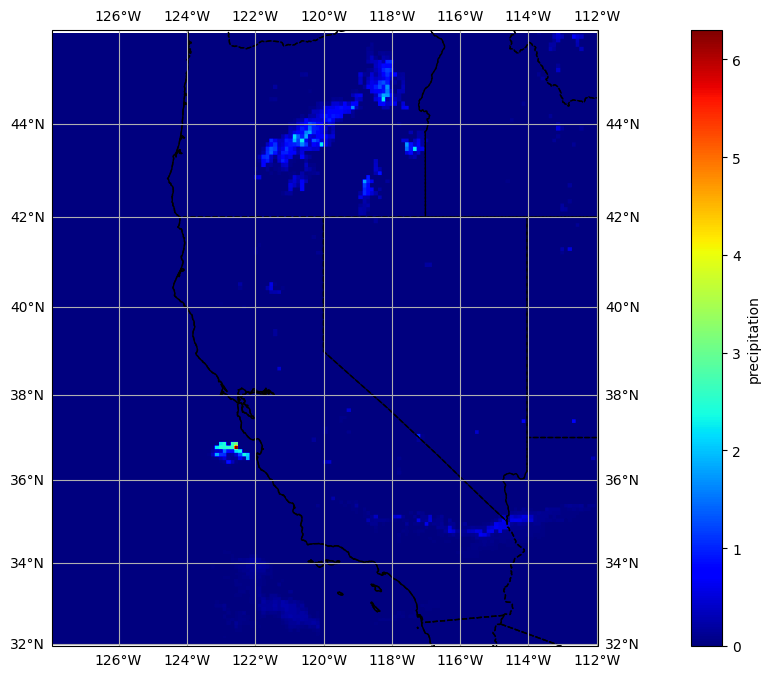

In [134]:
plot_cartopy(imerg, "precipitation", "precipitation", 1994)

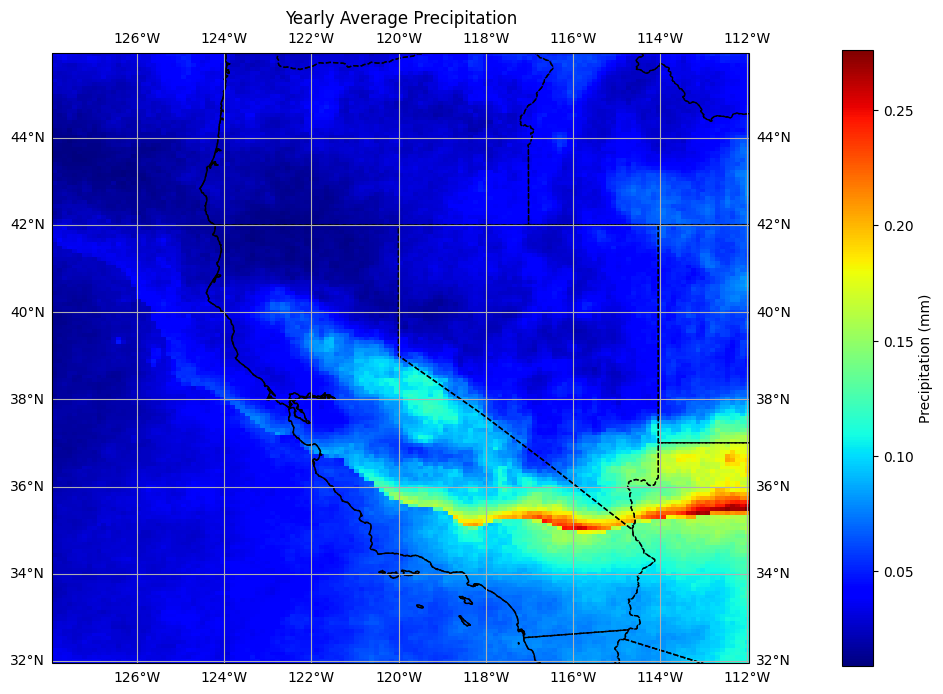

In [127]:
lons = imerg['lon'].values
lats = imerg['lat'].values
precipitation = imerg['precipitation']

# Calculate yearly average precipitation
mean_precip = imerg['precipitation'].mean(dim = 'time')

# Define extent based on your data
min_lon, max_lon = np.min(lons), np.max(lons)
min_lat, max_lat = np.min(lats), np.max(lats)

# Plotting with Cartopy
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot data
im = plt.imshow(mean_precip, extent=(min_lon, max_lon, min_lat, max_lat),
                cmap='jet', origin='lower', transform=ccrs.PlateCarree())
c_bar = plt.colorbar(im, label='Precipitation (mm)', orientation='vertical', pad=0.1)

# Add map features
ax.coastlines()
ax.gridlines(draw_labels=True)

ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='--')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Yearly Average Precipitation')

plt.show()

# plt.savefig(f'{file_name}.jpg', dpi = 300, bbox_inches = 'tight')
# plt.clf()

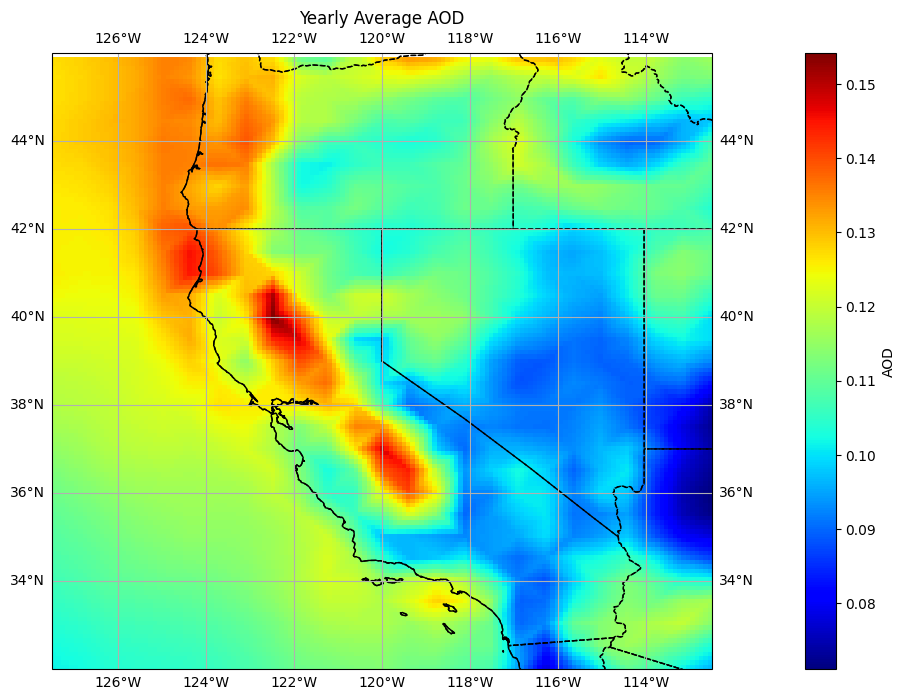

In [106]:
lons = aodana_new['lon'].values
lats = aodana_new['lat'].values
AODANA = aodana_new['AODANA']

# Calculate yearly average precipitation
mean_AOD = aodana_new['AODANA'].mean(dim = 'time')

# Define extent based on your data
min_lon, max_lon = np.min(lons), np.max(lons)
min_lat, max_lat = np.min(lats), np.max(lats)

# Plotting with Cartopy
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot data
im = plt.imshow(mean_AOD, extent=(min_lon, max_lon, min_lat, max_lat),
                cmap='jet', origin='lower', transform=ccrs.PlateCarree())
c_bar = plt.colorbar(im, label='AOD', orientation='vertical', pad=0.1)

# Add map features
ax.coastlines()
ax.gridlines(draw_labels=True)

ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='--')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Yearly Average AOD')

plt.show()

# plt.savefig(f'{file_name}.jpg', dpi = 300, bbox_inches = 'tight')
# plt.clf()

In [147]:
temp = xr.open_dataset("f000_cw.regrid.nc")

In [148]:
temp

<xarray.Dataset> Size: 2GB
Dimensions:  (lat: 141, time: 10224, lon: 161)
Coordinates:
  * lat      (lat) float64 1kB 32.0 32.1 32.2 32.3 32.4 ... 45.7 45.8 45.9 46.0
  * lon      (lon) float64 1kB -128.0 -127.9 -127.8 ... -112.2 -112.1 -112.0
  * time     (time) datetime64[ns] 82kB 2016-12-31T12:00:00 ... 2023-12-31T06...
Data variables:
    cw       (time, lat, lon) float64 2GB ...

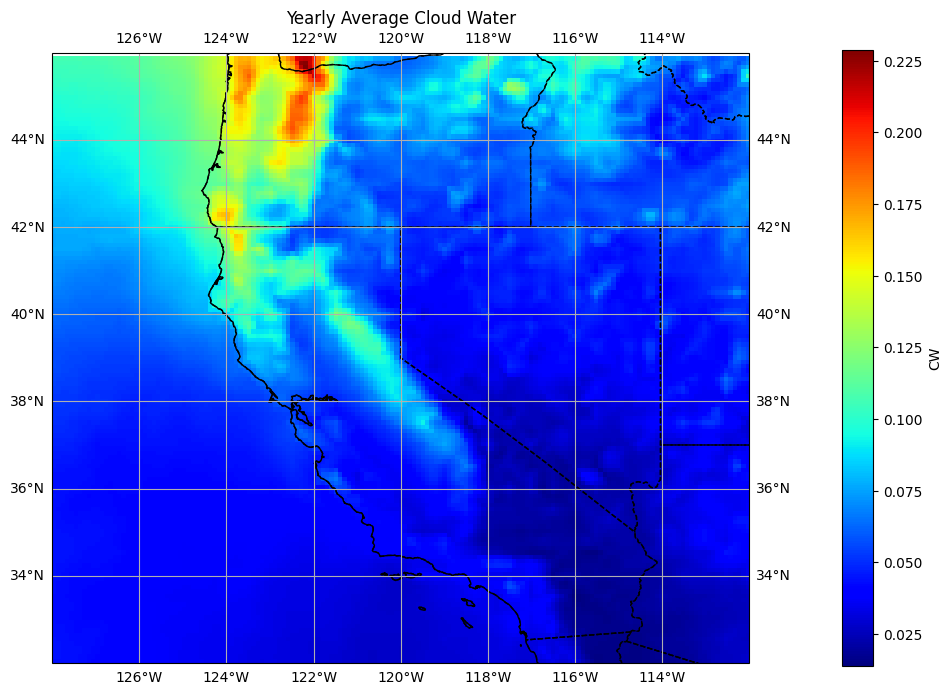

In [145]:
lons = f000cw_new['lon'].values
lats = f000cw_new['lat'].values
cw = f000cw_new['cw']

# Calculate yearly average precipitation
mean_cw = f000cw_new['cw'].mean(dim = 'time')

# Define extent based on your data
min_lon, max_lon = np.min(lons), np.max(lons)
min_lat, max_lat = np.min(lats), np.max(lats)

# Plotting with Cartopy
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot data
im = plt.imshow(mean_cw, extent=(min_lon, max_lon, min_lat, max_lat),
                cmap='jet', origin='lower', transform=ccrs.PlateCarree())
c_bar = plt.colorbar(im, label='CW', orientation='vertical', pad=0.1)

# Add map features
ax.coastlines()
ax.gridlines(draw_labels=True)

ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='--')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Yearly Average Cloud Water')

plt.show()